#TODO
- Compare algos to
    - experimental results
    - NIH web site

In [1]:
from typing import Iterable
import datetime
from collections import Counter
import statistics

In [2]:
from rdkit.Chem import AllChem as Chem
from rdkit import RDLogger
from rdkit.Chem import Draw, rdFMCS
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

print(rdkit.__version__)

2023.09.1


In [3]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [4]:
def enumerate_tauts(sml):
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    smls_tauts = [{} for _ in enumerators]
    for i, enumerator in enumerate(enumerators):
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [5]:
def check_same_keys(dict_list):
    start = datetime.datetime.now()
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    # print(f"check_same_keys took {datetime.datetime.now() - start} seconds")
    return True

Algorithm for processing Tautomer_database_release_3a:
1) Remove duplicate (keep only one row) Ref values--at initial inspection, seems like duplicate rows contain the same SMILES for SMILES_n OR keep all rows for a Ref, putting all the SMILES into a set 
2) For each row corresponding to a Ref,
    1) Read Size value
    2) Extract columns SMILES_n where n = 1 to Size
    3) Convert extracted SMILES_n to canonical using RDKit
    4) Use those several SMILES_n columns as experimental tautomers by creating a set of SMILES_n (or dictionary of SMILES_n:mol ?)
    5) Use only SMILES_1 to enumerate tautomers using various cheminformatics algorithms
    6) Compare experimental to cheminformatics results: Are there differences in count and canonical SMILES?

In [6]:
# Tautomer database from https://cactus.nci.nih.gov/download/tautomer/
file_name = "../data/Tautomer_database_release_3a.xlsx"
# file_name = "../data/Tautomer_database_release_3a_first.xlsx" # Only the first row, for speedy debugging
sheet_name = "Tautomer_database"
# file_name = "../data/8.sk.smi"
# file_name = "../data/12.sk.smi"

In [7]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [8]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )

# Lists for names of SMILES_n and InChI_n columns
SMILES_columns = [col for col in df.columns if col.startswith('SMILES_')]
InChI_columns = [col for col in df.columns if col.startswith('Std_InChI_')]

# Combined list of SMILES_n and InChI_n columns
numbered_columns = [elem for pair in zip(SMILES_columns, InChI_columns) for elem in pair]

# Select relevant columns in dataframe
df = df.select("Ref","Size",*numbered_columns)

# Melt dataframe: Break out each row's SMILES_n columns into its own row
df_melted = df.melt(id_vars=["Ref","Size"], value_vars=SMILES_columns, value_name="sml")

# Keep rows where SMILES is supplied
df_melted = df_melted.filter(pl.col('sml').is_not_null())

df_melted = df_melted.drop("variable")

# Remove duplicate rows, which are possible because a Ref can have multiple rows
df_melted = df_melted.unique()

# Add the RDKit molecule
#TODO Break this out into a function so can try with normalize(?) = False
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(lambda s: Chem.MolFromSmiles(s)).alias("mol"),
    ]
)

# Add the canonical SMILES
df_melted = df_melted.with_columns(
    [
        pl.col("mol").map_elements(lambda m: canon_sml_or_none(m)).alias("canon_sml"),
    ]
)
# print("df_melted, Ref=4")
# print(df_melted.filter(pl.col("Ref") == 4))

# Remove the input SMILES column; drop rows with any null values
df_melted = df_melted.drop("sml").drop_nulls()

# Drop duplicate (Ref + canonical SMILES) rows
df_melted = df_melted.unique(["Ref", "canon_sml"])

df_melted = df_melted.sort("Ref")
with pl.Config(fmt_str_lengths=1000):
    print(df_melted)

shape: (3_789, 4)
┌──────┬──────┬──────────────────────────────────┬─────────────────────────────────────────────────┐
│ Ref  ┆ Size ┆ mol                              ┆ canon_sml                                       │
│ ---  ┆ ---  ┆ ---                              ┆ ---                                             │
│ i64  ┆ i64  ┆ object                           ┆ str                                             │
╞══════╪══════╪══════════════════════════════════╪═════════════════════════════════════════════════╡
│ 1    ┆ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ CC(=O)CC(C)=O                                   │
│      ┆      ┆ 0x15440bbc0>                     ┆                                                 │
│ 1    ┆ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ CC(=O)/C=C(/C)O                                 │
│      ┆      ┆ 0x1543a5b60>                     ┆                                                 │
│ 2    ┆ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ c1c[nH]nn1            

In [9]:
df_melted.filter(pl.col("Ref") == 4)

Ref,Size,mol,canon_sml
i64,i64,object,str


In [10]:
def smls_tauts(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_dict = dict()
    for taut in tauts:
        tauts_dict.update({Chem.MolToSmiles(taut):taut})
    return tauts_dict

In [11]:
def tauts_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_list = []
    for taut in tauts:
        tauts_list.append(taut)
    return tauts_list

In [12]:
def tauts_as_sml_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

In [13]:
# Enumerate tautomers--this may take more than one minute
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("mol").map_elements(lambda m: tauts_as_sml_list(enumerator(), m)).alias("tauts" + enumerator.__name__),
        ]
    )

In [59]:
# Manually list tautomers created by NIH Tautomerizer
# https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl
# Settings:
#   steps: multi
#   Predicted tautomers by: All Rules
nih_sml_tauts = {
    "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O": [
        "COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O",
        "COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC3=C2[C@H]([C@@H](C1=C(OC)C(=C6C5=C1C2=C4C(=C3O)C(C=C(C4=C5C(=CC6=O)OC)OC)=O)O)[C@H](C)O)[C@H](C)O",
        "COC2=C3[C@H]([C@@H](C4=C(OC)C(=O)C6=C5C(=C1C(C(=C(C=C1OC)O)C2=O)C3=C45)C(=CC6=O)OC)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5=C3C1=C2C(=C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5C3=C1C2=C(C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
    ],
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1": [
        "CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=C)N2",
        "CSC1=NC(C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)=C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C",
        "CSC1NC(=C(C(=N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(=C1C(C=CC=C1)=[N+]([O-])O)C(=C(C)N2)C(=O)OC(C)C",
        "CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C",
    ],
    # 1704 a
    "Cc1cc(C=O)c(C)c(C=O)c1": [
        "CC1=CC(C(C(=C1)C=O)=C)=CO",
        "C[CH]1C=C([C](C(=C1)C=O)=[CH2])C=O",
    ],
    # 1704 b
    "C=c1c(C=O)cc(C)cc1=CO": [
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
        "C=C1C(C=C(C=C1C=O)C)C=O",
        "C=C1C(=CC(=CC1C=O)C)C=O",
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
    ],
    # 890a
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54": [
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC6=C(O)C1=C(O)C=C(OC)C2=C1C(=C3C(=C(C(=C4C(C=C(C2=C34)OC)=O)O)OC)C[C@H](C)OC(=O)C5=CC=C(C=C5)O)C6=C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C(CC(C(=C34)C5=O)=O)OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C1C(=C(OC)CC2=O)C5=C3C(=C4O)C(=O)C=C5OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(C(=C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)O)OC)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC2=C(C3=C1C(=C(C(C5=C1C(=C4C(=CC(C(=C2O)C34)=O)OC)C(=CC5=O)OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC3=C(C1=C4C(=C(C(=C5C(C=C(C(=C2C(=CC(C(=C12)C3=O)=O)OC)C45)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
    ],
    # 890b
    #   3 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
    #   7 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   3 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   6 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    "COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43": [
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(=C(C(C3=C45)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)O)OC)OC)O)C7=O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(C(=C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)O)O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(=C(C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)=C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)O)OC)OC)O)O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5=C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)=O)OC)OC)O)C7=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(=C6C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(C6=C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)=O)OC)OC)=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(=O)C3=CC=C(C=C3)O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(O)=C3C=CC(C=C3)=O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(O)=C7C=CC(C=C7)=O)OC)=O)O)OC",
    ],
    # 1688a
    #   1 tautomer(s) generated using PT_03_00 - simple (aliphatic) imine
    #   2 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_16_00 - nitroso/oxime
    #   1 tautomer(s) generated using PT_36_00 - oxime/nitrone: 1,2 H-shift
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(/C=[N+](\[O-])C(C)(C)/C(C)=N/O)OCC": [
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)=[NH+][O-])OCC",
        "C=C(C1N(O)C(C)(C)C(=[N+]1[O-])C)OCC",
    ],
    # 1688b
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_39_00 - nitrone/azoxy or Behrend rearrangement
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(OCC)C1N(O)C(C)(C)C(C)=[N+]1[O-]": [
        "C=C(OCC)C1[NH+](C(C(N1O)(C)C)=C)[O-]",
        "C=C(OCC)C1=[N+](C(C(N1O)(C)C)C)[O-]",
        "C=C(OCC)C=[N+]([O-])C(C)(C)C(C)=NO",
    ],
    # 1512a
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    "CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1": [
        "CC[P]2(OC1C(=CC(=CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P]2(OC1=C(C=C(CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P](CC)(C1=CC=CC=C1)=NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O",
    ],
    # 1512b
    #   3 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    "CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1": [
        "CC[P](CC)(=NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC[P](CC)(=NC1=CC(=CC(C(C)(C)C)C1=O)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C5=CC=CC=C5",
        "CC[P]5(CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O5)C6=CC=CC=C6",
    ],
}

In [60]:
# Function to canonicalize a list of SMILES
def canonicalize_smiles(smls_list):
    canonical_smiles = []
    for sml in smls_list:
        mol = Chem.MolFromSmiles(sml)
        if mol:
            canonical = Chem.MolToSmiles(mol)
            canonical_smiles.append(canonical)
        else:
            mol = Chem.MolFromSmiles(sml, sanitize=False)
            if mol:
                canonical = Chem.MolToSmiles(mol)
                canonical_smiles.append(canonical)
            else:
                canonical_smiles.append(None)
                print("Molecule couldn't be created")
    # Eliminate duplicates by turning list into a set, then back to a list so can go in dataframe
    canonical_smiles_unique = list(set(canonical_smiles))
    return canonical_smiles_unique

In [61]:
nih_sml_tauts_canon = {key: canonicalize_smiles(value) for key, value in nih_sml_tauts.items()}

In [62]:
nih_inputs = nih_sml_tauts_canon.keys()
nih_tauts = nih_sml_tauts_canon.values()
df_nih = pl.DataFrame({"canon_sml": nih_inputs, "tautsNIH": nih_tauts})
with pl.Config(fmt_str_lengths=1000):
    print(df_nih)

shape: (10, 2)
┌─────────────────────────────────────────────────┬────────────────────────────────────────────────┐
│ canon_sml                                       ┆ tautsNIH                                       │
│ ---                                             ┆ ---                                            │
│ str                                             ┆ list[str]                                      │
╞═════════════════════════════════════════════════╪════════════════════════════════════════════════╡
│ COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O ┆ ["COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c( │
│ )c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C ┆ OC)c(c42)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O)C(= │
│ )O                                              ┆ O)C=C1OC", "COC1=CC(=O)C2=c3c1c1c(OC)cc(=O)c4c │
│                                                 ┆ (=O)c(OC)c5c(c3C(C(OC)=C2O)[C@@H]([C@H](C)O)[C │
│                                                 ┆ @@H]5[C@H](C)O)c1=4", … 

In [63]:
# Merge in NIH tauts by left-joining on canon_sml

# Ensure no tautsNIH columns already exist--can cause additional column tautsNIH_right to be created
columsNIH = [col for col in df_melted.columns if col.startswith('tautsNIH')]
for col in columsNIH:
    df_melted = df_melted.drop(col)
    
df_melted = df_melted.join(df_nih, on="canon_sml", how="left")


In [64]:
df_melted.filter(pl.col("Ref") == 1704)


Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH
i64,i64,object,str,list[str],list[str],list[str]
1704,2,<rdkit.Chem.rdchem.Mol object at 0x1543ed310>,"""Cc1cc(C=O)c(C)…","[""Cc1cc(C=O)c(C)c(C=O)c1""]","[""Cc1cc(C=O)c(C)c(C=O)c1""]","[""C=C1C(C=O)=CC(C)C=C1C=O"", ""C=c1c(C=O)cc(C)cc1=CO""]"
1704,2,<rdkit.Chem.rdchem.Mol object at 0x16e320eb0>,"""C=c1c(C=O)cc(C…","[""C=C1C(C=O)=CC(C)=CC1C=O"", ""C=c1c(C=O)cc(C)cc1=CO""]","[""C=c1c(C=O)cc(C)cc1=CO""]","[""Cc1cc(C=O)c(C)c(C=O)c1"", ""C=C1C(C=O)=CC(C)C=C1C=O"", ""C=C1C(C=O)=CC(C)=CC1C=O""]"


In [65]:
# Replace None (null) values in tautsNIH to prevent error when flatten nested list into non-nested (flat) list
tautsNIH = df_melted["tautsNIH"].to_list()
tautsNIH_no_nulls = [val if val is not None else [] for val in tautsNIH]
tautsNIH_no_nulls_series = pl.Series(tautsNIH_no_nulls)
df_melted = df_melted.with_columns(tautsNIH_no_nulls_series.alias("tautsNIH"))

In [66]:
# Merge tautomer smls for each row for same ref: 
#   assumption is that all input smls correspond to legitimate tautomers
other_columns = [col for col in df_melted.columns if col not in ['Ref']]

df_melted_aggregated = (
    df_melted.group_by('Ref')
    .agg(*other_columns)
)
df_melted_aggregated.head(3)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]]
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""CC(=O)CC(C)=O"", ""CC(=O)/C=C(/C)O""]","[[""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[], []]"
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[[""c1cn[nH]n1"", ""c1c[nH]nn1""], [""c1cn[nH]n1"", ""c1c[nH]nn1""]]","[[""c1cn[nH]n1"", ""c1c[nH]nn1""], [""c1cn[nH]n1"", ""c1c[nH]nn1""]]","[[], []]"
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""], [""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]]","[[""C=C1C=CNN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""], [""C=C1C=CNN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]]","[[], []]"


In [67]:
#Debugging: Inspect row where NIH tautomers added
df_melted_aggregated.filter(pl.col("Ref").is_in([888, 889]))

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]]
888,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54""]","[[""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c4c4c(c(O)cc(OC)c24)C(=O)C5OC)C(OC)C(=O)C=3C(=O)C1"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c5c(c3=C(C(OC)C2=O)C([C@H](C)O)C=5[C@H](C)O)c41"", … ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c4c4c2=C(OC)CC(=O)C=4C(=O)C5OC)=C(OC)C(=O)C3=C(O)C1""], [""COC1=C2c3c4c(c(O)cc(OC)c4c4c5c(c(O)c(OC)c(c35)=C([C@H](C)O)C2[C@H](C)O)C(=O)CC=4OC)C1=O"", ""COC1=CC(=O)C2=C(O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)C(OC)=CC(=O)C6=C(O)C4OC"", … ""COc1c2c3c4c5c(c(=O)cc(OC)c5c5c(OC)cc(O)c(c1=O)c35)=C(O)C(OC)C4=C([C@H](C)O)C2[C@H](C)O""]]","[[""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", ""COC1=c2c3c4c5c(c(=C(C)O)c(=C(C)O)c6c5c2C(C(=O)C=6OC)C(O)=C1)C(OC)C(O)=C4C(=O)CC3OC"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1C(OC)C(=O)C=6C(O)=CC5OC)C(OC)CC(=O)C=4C(=O)C2OC""], [""COc1cc(O)c2c(O)c(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC"", ""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", … ""COC1=CC(=O)C2C(O)=C(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC""]]","[[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(=O)c4c(=O)c(OC)c5c(c3C(C(OC)=C2O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)c1=4"", … ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)C41""], []]"
889,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H]([C@@H](C)O)[C@H]2[C@@H](C)O"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@H]([C@@H](C)O)[C@H]6[C@@H](C)O)c23)c54""]","[[""COc1c2c3c4c5c(c(=O)cc(OC)c5c5c(OC)cc(=O)c(c1O)c35)=C(O)C(OC)C4=C([C@@H](C)O)C2[C@@H](C)O"", ""COC1=C2c3c4c5c(c6c3=C(C(=O)CC=6OC)C1=O)=C(OC)CC(=O)C=5C(=O)C(OC)C4=C([C@@H](C)O)C2[C@@H](C)O"", … ""COC1=CC(=O)C2C(O)=C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c5c6c(c1c2c35)=C(OC)C=C(O)C6C(=O)C=4OC""], [""COC1=CC(=O)C2C(O)=C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)c4c(OC)c(O)c5c6c(c1c2c3c46)C(OC)=CC5=O"", ""COC1=CC(=O)C2C(=O)C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)C4=C(OC)C(=O)c5c(O)cc(OC)c6c1c2c3c4c56"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c4C(=C([C@@H](C)O)C3[C@@H](C)O)C(OC)C(=O)C=2C(=O)CC=1OC""]]","[[""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", ""COC1=c2c3c4c5c(c(=C(C)O)c(=C(C)O)c6c5c2C(C(=O)C=6OC)C(O)=C1)C(OC)C(O)=C4C(=O)CC3OC"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1C(OC)C(=O)C=6C(O)=CC5OC)C(OC)CC(=O)C=4C(=O)C2OC""], [""COc1cc(O)c2c(O)c(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC"", ""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", … ""COC1=CC(=O)C2C(O)=C(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC""]]","[[], []]"


In [68]:
# For each tautomers column, created a flattened column to merge same canonical SMILES

# List of columns with tautomers
tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('tauts')]
print(tauts_columns)
for tauts_column in tauts_columns:
    print(tauts_column)
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(tauts_column).map_elements(lambda m: list(set([item for row in m for item in row]))).alias("flat_" + tauts_column),
        ]
    )
df_melted_aggregated.head(3)

['tautsTautomerEnumerator', 'tautsGetV1TautomerEnumerator', 'tautsNIH']
tautsTautomerEnumerator


tautsGetV1TautomerEnumerator
tautsNIH


Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str]
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""CC(=O)CC(C)=O"", ""CC(=O)/C=C(/C)O""]","[[""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[], []]","[""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""CC(=O)CC(C)=O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",[]
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[[""c1cn[nH]n1"", ""c1c[nH]nn1""], [""c1cn[nH]n1"", ""c1c[nH]nn1""]]","[[""c1cn[nH]n1"", ""c1c[nH]nn1""], [""c1cn[nH]n1"", ""c1c[nH]nn1""]]","[[], []]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]",[]
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""], [""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]]","[[""C=C1C=CNN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""], [""C=C1C=CNN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]]","[[], []]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[""C=C1C=CNN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]",[]


In [69]:
# Add tautomer counts

# Create list of flat tautomer columns
flat_tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('flat_tauts')]

# Add tautomers from Tautomer database
flat_tauts_columns.append("canon_sml")
for flat_tauts_column in flat_tauts_columns:
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(flat_tauts_column).map_elements(lambda t: len(t)).alias("n_" + flat_tauts_column.replace("flat_", "")),
        ]
    )
df_melted_aggregated.drop(["tautsNIH","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(pl.col("n_canon_sml") > 4)

Ref,Size,mol,canon_sml,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml
i64,list[i64],list[extension],list[str],list[str],list[str],list[str],i64,i64,i64,i64
926,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""CCOC(=O)CC(=O)C/C(O)=C/C(=O)OC"", ""CCOC(=O)/C=C(\O)CC(=O)CC(=O)OC"", … ""CCOC(=O)CC(=O)CC(=O)CC(=O)OC""]","[""CCOC(=O)CC(=O)C=C(O)C=C(O)OC"", ""CCOC(O)=CC(O)=CC(=O)CC(=O)OC"", … ""CCOC(=O)CC(=O)C=C(O)CC(=O)OC""]","[""CCOC(=O)CC(=O)C=C(O)C=C(O)OC"", ""CCOC(O)=CC(O)=CC(=O)CC(=O)OC"", … ""CCOC(=O)CC(=O)C=C(O)CC(=O)OC""]",[],21,21,0,5
927,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""CCOC(=O)CC(=O)C(CC)/C(O)=C/C(=O)OC"", ""CCOC(=O)C/C(O)=C(\CC)C(=O)CC(=O)OC"", … ""CCOC(=O)/C=C(\O)C(CC)/C(O)=C/C(=O)OC""]","[""CCOC(=O)C=C(O)C(CC)C(O)=CC(=O)OC"", ""CCOC(O)=CC(O)=C(CC)C(=O)C=C(O)OC"", … ""CCOC(=O)CC(=O)C(CC)C(O)=CC(=O)OC""]","[""CCOC(=O)C=C(O)C(CC)C(O)=CC(=O)OC"", ""CCOC(O)=CC(O)=C(CC)C(=O)C=C(O)OC"", … ""CCOC(=O)CC(=O)C(CC)C(O)=CC(=O)OC""]",[],21,21,0,5
928,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""CCOC(=O)C(C)C(=O)CC(=O)CC(=O)OC"", ""CCOC(=O)/C(C)=C(\O)CC(=O)CC(=O)OC"", … ""CCOC(=O)C(C)C(=O)C/C(O)=C/C(=O)OC""]","[""CCOC(=O)C(C)=C(O)C=C(O)C=C(O)OC"", ""CCOC(=O)C(C)=C(O)C=C(O)CC(=O)OC"", … ""CCOC(=O)C(C)C(O)=CC(O)=CC(=O)OC""]","[""CCOC(=O)C(C)=C(O)C=C(O)C=C(O)OC"", ""CCOC(=O)C(C)=C(O)C=C(O)CC(=O)OC"", … ""CCOC(=O)C(C)C(O)=CC(O)=CC(=O)OC""]",[],21,21,0,5
929,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""CC/C(C(=O)OC)=C(/O)CC(=O)CC(=O)OC"", ""CCC(C(=O)OC)/C(O)=C/C(=O)CC(=O)OC"", … ""CCC(C(=O)CC(=O)CC(=O)OC)C(=O)OC""]","[""CCC(C(=O)OC)C(O)=CC(=O)C=C(O)OC"", ""CCC(C(=O)OC)C(O)=CC(=O)CC(=O)OC"", … ""CCC(C(=O)C=C(O)CC(=O)OC)=C(O)OC""]","[""CCC(C(=O)OC)C(O)=CC(=O)C=C(O)OC"", ""CCC(C(=O)OC)C(O)=CC(=O)CC(=O)OC"", … ""CCC(C(=O)C=C(O)CC(=O)OC)=C(O)OC""]",[],21,21,0,5
930,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""COC(=O)CC(=O)CC(=O)C(Cl)C(=O)OC"", ""COC(=O)CC(=O)/C=C(\O)C(Cl)C(=O)OC"", … ""COC(=O)CC(=O)C/C(O)=C(\Cl)C(=O)OC""]","[""COC(=O)CC(=O)C=C(O)C(Cl)C(=O)OC"", ""COC(=O)CC(O)=CC(=O)C(Cl)C(=O)OC"", … ""COC(=O)C=C(O)CC(=O)C(Cl)=C(O)OC""]","[""COC(=O)CC(=O)C=C(O)C(Cl)C(=O)OC"", ""COC(=O)CC(O)=CC(=O)C(Cl)C(=O)OC"", … ""COC(=O)C=C(O)CC(=O)C(Cl)=C(O)OC""]",[],21,21,0,5
931,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""CCOC(=O)/C(Cl)=C(\O)C/C(O)=C/C(=O)OC"", ""CCOC(=O)C(Cl)C(=O)CC(=O)CC(=O)OC"", … ""CCOC(=O)C(Cl)/C(O)=C/C(=O)CC(=O)OC""]","[""CCOC(=O)C(Cl)=C(O)CC(=O)C=C(O)OC"", ""CCOC(=O)C(Cl)=C(O)C=C(O)C=C(O)OC"", … ""CCOC(=O)C(Cl)C(=O)CC(O)=CC(=O)OC""]","[""CCOC(=O)C(Cl)=C(O)CC(=O)C=C(O)OC"", ""CCOC(=O)C(Cl)=C(O)C=C(O)C=C(O)OC"", … ""CCOC(=O)C(Cl)C(=O)CC(O)=CC(=O)OC""]",[],21,21,0,5
932,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>, … <rdkit.Chem.rdchem.Mol object at 0x1543ded50>]","[""CCOC(=O)C(F)C(=O)C/C(O)=C/C(=O)OC"", ""CCOC(=O)/C(F)=C(\O)C/C(O)=C/C(=O)OC"", … ""CCOC(=O)/C(F)=C(\O)CC(=O)CC(=O)OC""]","[""CCOC(=O)C(F)C(=O)C=C(O)CC(=O)OC"", ""CCOC(O)=C(F)C(=O)C=C(O)CC(=O)OC"", … ""CCOC(=O)C(F)C(=O)CC(O)=CC(=O)OC""]","[""CCOC(=O)C(F)C(=O)C=C(O)CC(=O)OC"", ""CCOC(O)=C(F)C(=O)C=C(O)CC(=O)OC"", … ""CCOC(=O)C(F)C(=O)CC(O)=CC(=O)OC""]",[],21,21,0,5
1213,"[5, 5, … 5]","[<rdkit.Ch

In [70]:
def sets_are_equal(
        *iterables: Iterable,
):
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            return False  # Return False if keys are not the same
    return True  # Return True if all dictionaries have the same keys

In [71]:
# Check if sets of tautomers are the same for different algorithms
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
        # Check if different algos produce same set of tautomers
        pl.struct(["flat_tautsTautomerEnumerator", "flat_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: sets_are_equal(x["flat_tautsTautomerEnumerator"], x["flat_tautsGetV1TautomerEnumerator"]))
        .alias("tauts_same"),
        # Calculate difference in number of tautomers between algos
        pl.struct(["n_tautsTautomerEnumerator", "n_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: x["n_tautsTautomerEnumerator"] - x["n_tautsGetV1TautomerEnumerator"])
        .alias("n_tauts_diff"),
    ]
)
df_melted_aggregated.filter(abs(pl.col("n_tauts_diff")) > 300)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml,tauts_same,n_tauts_diff
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],i64,i64,i64,i64,bool,i64
888,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54""]","[[""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c4c4c(c(O)cc(OC)c24)C(=O)C5OC)C(OC)C(=O)C=3C(=O)C1"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c5c(c3=C(C(OC)C2=O)C([C@H](C)O)C=5[C@H](C)O)c41"", … ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c4c4c2=C(OC)CC(=O)C=4C(=O)C5OC)=C(OC)C(=O)C3=C(O)C1""], [""COC1=C2c3c4c(c(O)cc(OC)c4c4c5c(c(O)c(OC)c(c35)=C([C@H](C)O)C2[C@H](C)O)C(=O)CC=4OC)C1=O"", ""COC1=CC(=O)C2=C(O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)C(OC)=CC(=O)C6=C(O)C4OC"", … ""COc1c2c3c4c5c(c(=O)cc(OC)c5c5c(OC)cc(O)c(c1=O)c35)=C(O)C(OC)C4=C([C@H](C)O)C2[C@H](C)O""]]","[[""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", ""COC1=c2c3c4c5c(c(=C(C)O)c(=C(C)O)c6c5c2C(C(=O)C=6OC)C(O)=C1)C(OC)C(O)=C4C(=O)CC3OC"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1C(OC)C(=O)C=6C(O)=CC5OC)C(OC)CC(=O)C=4C(=O)C2OC""], [""COc1cc(O)c2c(O)c(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC"", ""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", … ""COC1=CC(=O)C2C(O)=C(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC""]]","[[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(=O)c4c(=O)c(OC)c5c(c3C(C(OC)=C2O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)c1=4"", … ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)C41""], []]","[""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c4c4c(c(O)cc(OC)c24)C(=O)C5OC)C(OC)C(=O)C=3C(=O)C1"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c5c(c3=C(C(OC)C2=O)C([C@H](C)O)C=5[C@H](C)O)c41"", … ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c4c4c2=C(OC)CC(=O)C=4C(=O)C5OC)=C(OC)C(=O)C3=C(O)C1""]","[""COc1cc(O)c2c(O)c(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)C=C(O)C6=C(O)C4OC"", ""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C6C(O)=CC5OC)c24)=C(OC)CC3=O"", … ""COc1cc(O)c2c(O)c(OC)c3c(C(C)O)c(C(C)=O)c4c5c6c(c1c2c35)C(OC)CC(=O)C6C(=O)C4OC""]","[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(=O)c4c(=O)c(OC)c5c(c3C(C(OC)=C2O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)c1=4"", … ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)C41""]",107,656,9,2,false,-549
889,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H]([C@@H](C)O)[C@H]2[C@@H](C)O"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@H]([C@@H](C)O)[C@H]6[C@@H](C)O)c23)c54""]","[[""COc1c2c3c4c5c(c(=O)cc(OC)c5c5c(OC)cc(=O)c(c1O)c35)=C(O)C(OC)C4=C([C@@H](C)O)C2[C@@H](C)O"", ""COC1=C2c3c4c5c(c6c3=C(C(=O)CC=6OC)C1=O)=C(OC)CC(=O)C=5C(=O)C(OC)C4=C([C@@H](C)O)C2[C@@H](C)O"", … ""COC1=CC(=O)C2C(O)=C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c5c6c(c1c2c35)=C(OC)C=C(O)C6C(=O)C=4OC""], [""COC1=CC(=O)C2C(O)=C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)c4c(OC)c(O)c5c6c(c1c2c3c46)C(OC)=CC5=O"", ""COC1=CC(=O)C2C(=O)C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)C4=C(OC)C(=O)c5c(O)cc(OC)c6c1c2c3c4c56"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c4C(=C([C@@H](C)O)C3[C@@H](C)O)C(OC)C(=O)C=2C(=O)CC=1OC""]]","[[""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(O

In [72]:
# Narrow down to rows where algos give different sets of tautomers
df_melted_aggregated_different = df_melted_aggregated.filter(pl.col("tauts_same") == False)

df_melted_aggregated_different.drop(["mol","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(abs(pl.col("n_tauts_diff")) < 2).filter(abs(pl.col("n_tautsTautomerEnumerator")) < 4).filter(abs(pl.col("n_tautsGetV1TautomerEnumerator")) < 4).sort(abs(pl.col("n_tauts_diff")), descending=True)

Ref,Size,canon_sml,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml,tauts_same,n_tauts_diff
i64,list[i64],list[str],list[list[str]],list[str],list[str],list[str],i64,i64,i64,i64,bool,i64
29,"[2, 2]","[""N=c1cccccc1O"", ""Nc1cccccc1=O""]","[[], []]","[""N=c1cccccc1O"", ""N=C1C=CC=CCC1=O"", ""Nc1cccccc1=O""]","[""N=c1cccccc1O"", ""Nc1cccccc1=O""]",[],3,2,0,2,false,1
30,"[2, 2]","[""Oc1ccccc/c1=N\c1ccccc1"", ""O=c1cccccc1Nc1ccccc1""]","[[], []]","[""O=c1cccccc1Nc1ccccc1"", ""O=C1CC=CC=CC1=Nc1ccccc1"", ""Oc1cccccc1=Nc1ccccc1""]","[""O=c1cccccc1Nc1ccccc1"", ""Oc1cccccc1=Nc1ccccc1""]",[],3,2,0,2,false,1
31,"[2, 2]","[""Oc1ccccc/c1=N\c1ccc(Br)cc1"", ""O=c1cccccc1Nc1ccc(Br)cc1""]","[[], []]","[""O=c1cccccc1Nc1ccc(Br)cc1"", ""O=C1CC=CC=CC1=Nc1ccc(Br)cc1"", ""Oc1cccccc1=Nc1ccc(Br)cc1""]","[""O=c1cccccc1Nc1ccc(Br)cc1"", ""Oc1cccccc1=Nc1ccc(Br)cc1""]",[],3,2,0,2,false,1
32,"[2, 2]","[""O=c1cccccc1Nc1ccc(Cl)cc1"", ""Oc1ccccc/c1=N\c1ccc(Cl)cc1""]","[[], []]","[""O=c1cccccc1Nc1ccc(Cl)cc1"", ""Oc1cccccc1=Nc1ccc(Cl)cc1"", ""O=C1CC=CC=CC1=Nc1ccc(Cl)cc1""]","[""O=c1cccccc1Nc1ccc(Cl)cc1"", ""Oc1cccccc1=Nc1ccc(Cl)cc1""]",[],3,2,0,2,false,1
33,"[2, 2]","[""Oc1ccccc/c1=N\n1cccc1"", ""O=c1cccccc1Nn1cccc1""]","[[], []]","[""Oc1cccccc1=Nn1cccc1"", ""O=c1cccccc1Nn1cccc1"", ""O=C1CC=CC=CC1=Nn1cccc1""]","[""Oc1cccccc1=Nn1cccc1"", ""O=c1cccccc1Nn1cccc1""]",[],3,2,0,2,false,1
34,"[2, 2]","[""Oc1ccccc/c1=N\n1cncn1"", ""O=c1cccccc1Nn1cncn1""]","[[], []]","[""O=C1CC=CC=CC1=Nn1cncn1"", ""O=c1cccccc1Nn1cncn1"", ""Oc1cccccc1=Nn1cncn1""]","[""O=c1cccccc1Nn1cncn1"", ""Oc1cccccc1=Nn1cncn1""]",[],3,2,0,2,false,1
35,[2],"[""O=c1cccccc1O""]",[[]],"[""O=C1C=CC=CCC1=O"", ""O=c1cccccc1O""]","[""O=c1cccccc1O""]",[],2,1,0,1,false,1
62,"[2, 2]","[""C1=C(c2ccccc2)NN=C(c2ccccc2)C1"", ""c1ccc(C2=NN=C(c3ccccc3)CC2)cc1""]","[[], []]","[""C1=C(c2ccccc2)NN=C(c2ccccc2)C1"", ""c1ccc(C2=NN=C(c3ccccc3)CC2)cc1""]","[""C1=C(c2ccccc2)NNC(c2ccccc2)=C1"", ""C1=C(c2ccccc2)NN=C(c2ccccc2)C1"", ""c1ccc(C2=NN=C(c3ccccc3)CC2)cc1""]",[],2,3,0,2,false,-1
71,"[2, 2]","[""C1=C(c2ccccc2)NC(c2ccccc2)=NC1(c1ccccc1)c1ccccc1"", ""C1=C(c2ccccc2)N=C(c2ccccc2)NC1(c1ccccc1)c1ccccc1""]","[[], []]","[""C1=C(c2ccccc2)N=C(c2ccccc2)NC1(c1ccccc1)c1ccccc1"", ""C1=C(c2ccccc2)NC(c2ccccc2)=NC1(c1ccccc1)c1ccccc1""]","[""C1=C(c2ccccc2)N=C(c2ccccc2)NC1(c1ccccc1)c1ccccc1"", ""c1ccc(C2=NC(c3ccccc3)=NC(c3ccccc3)(c3ccccc3)C2)cc1"", ""C1=C(c2ccccc2)NC(c2ccccc2)=NC1(c1ccccc1)c1ccccc1""]",[],2,3,0,2,false,-1


In [73]:
def second_highest_frequency(lst):
    # Count frequencies of elements in the list
    frequencies = Counter(lst)
    
    # Find the second highest frequency
    unique_frequencies = sorted(set(frequencies.values()), reverse=True)
    
    # Find the second highest frequency value(s)
    second_highest_freq = unique_frequencies[1] if len(unique_frequencies) > 1 else unique_frequencies[0]
        
    return second_highest_freq

In [74]:
n_tauts_diff = df_melted_aggregated["n_tauts_diff"].to_list()
n_tauts_diff_no_zeros = [diff for diff in n_tauts_diff if diff != 0]
n_tauts_diff_positive = [diff for diff in n_tauts_diff_no_zeros if diff > 0]
n_tauts_diff_negative = [diff for diff in n_tauts_diff_no_zeros if diff < 0]
print(f"{len(n_tauts_diff)=}")
print(f"{len(n_tauts_diff_no_zeros)=}")
print(f"{len(n_tauts_diff_positive)=}")
print(f"{len(n_tauts_diff_negative)=}")

statistics.mean(n_tauts_diff)

len(n_tauts_diff)=1773
len(n_tauts_diff_no_zeros)=544
len(n_tauts_diff_positive)=135
len(n_tauts_diff_negative)=409


-4.6418499717992106

In [75]:
def stats_for_list(
        my_list
):
    stats = {"mean":statistics.mean(my_list), "median":statistics.median(my_list), "mode":statistics.mode(my_list), "std dev":statistics.stdev(my_list)}
    for stat, value in stats.items():
        if stat in ["mean", "std dev"]:
            print(f"{stat:10} {value:.2f}")
        else:
            print(f"{stat:10} {value:}")
    return stats

In [76]:
stats_for_list(n_tauts_diff_no_zeros)

mean       -15.13
median     -2.0
mode       -1
std dev    52.98


{'mean': -15.128676470588236,
 'median': -2.0,
 'mode': -1,
 'std dev': 52.98248420815611}

In [77]:
stats_for_list(n_tauts_diff_positive)

mean       7.00
median     1
mode       1
std dev    28.42


{'mean': 7, 'median': 1, 'mode': 1, 'std dev': 28.422452760019187}

In [78]:
stats_for_list(n_tauts_diff_negative)

mean       -22.43
median     -4
mode       -1
std dev    57.05


{'mean': -22.43276283618582,
 'median': -4,
 'mode': -1,
 'std dev': 57.05394765985538}

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


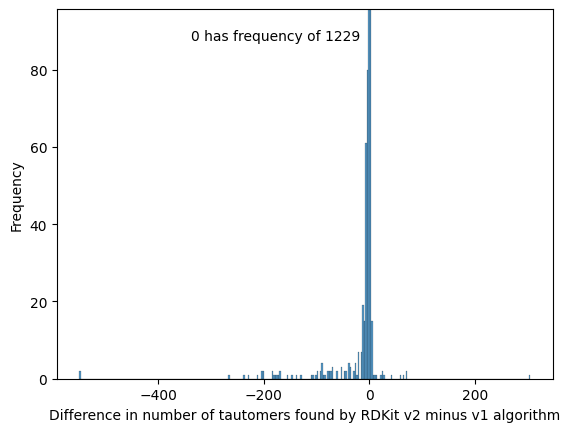

In [79]:
# Plot histogram of n_tauts_diff

sns.histplot(n_tauts_diff, bins=300)  # Adjust bins as needed
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
# plt.title('Histogram using Seaborn')
largest_y_value = second_highest_frequency(n_tauts_diff)

plt.ylim(0, largest_y_value * 1.1)

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
plt.text(0, largest_y_value, f'0 has frequency of {frequency_at_zero}  ', ha='right', va='bottom')

plt.show()


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


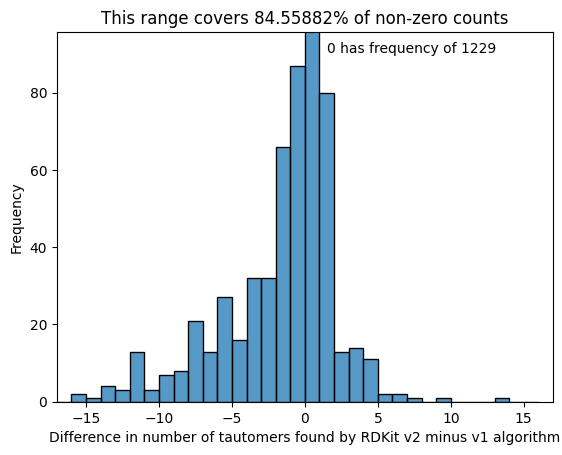

In [80]:
# Plot histogram of n_tauts_diff

x_len = 17
bins = range(-1 * x_len, x_len, 1)

n_tauts_diff_no_zeros_this_range = [diff for diff in n_tauts_diff_no_zeros if abs(diff) <= x_len]

non_zero_counts_this_range = len(n_tauts_diff_no_zeros_this_range) / len(n_tauts_diff_no_zeros)

sns.histplot(n_tauts_diff, bins=bins)
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
plt.title(f'This range covers {non_zero_counts_this_range:.5%} of non-zero counts')
largest_y_value = second_highest_frequency(n_tauts_diff)

plt.ylim(0, largest_y_value * 1.1)

plt.xlim(-1 * x_len, x_len)

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
plt.text(1.5, largest_y_value * 1.03, f'0 has frequency of {frequency_at_zero}', ha='left', va='bottom')

plt.show()

In [81]:
second_highest_frequency(n_tauts_diff)

87

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

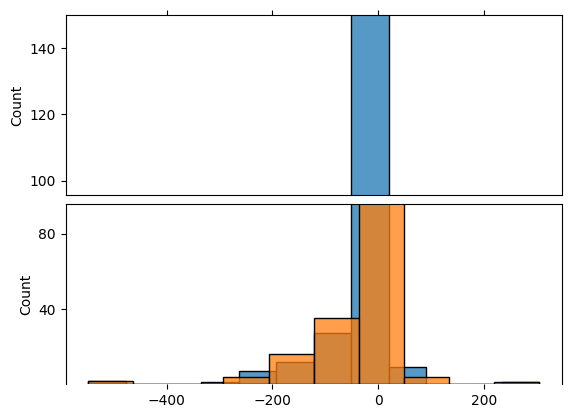

In [82]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # Adjust space between axes

# Plot the same data on both axes
sns.histplot(
    n_tauts_diff, 
    # bins=10, 
    ax=ax1)  # Adjust bins as needed
sns.histplot(
    n_tauts_diff, 
    # bins=10, 
    ax=ax2)  # Adjust bins as needed

# Get the second-highest frequency
greatest_y_lower_plot = 1.1 * second_highest_frequency(n_tauts_diff)

# Set y-axis limits on both subplots
# max_val = max(sns.histplot(n_tauts_diff, bins=10, ax=ax1).get_yticks()[1:])
ax2.set_ylim(0, greatest_y_lower_plot)

# Adjust the y-axis limit on the second plot to create a break
max_val = max(sns.histplot(n_tauts_diff, bins=10, ax=ax2).get_yticks()[1:])
ax1.set_ylim(greatest_y_lower_plot, max_val * 1.5)  # Adjust the range for the second plot

# Hide the overlapping portion of the y-axis between the two plots
ax2.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Hide top x-axis labels on the first plot

# Set the y-axis break indicator line
ax1.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))

plt.show()

In [83]:
def align_lists(
        list1,
        list2,
        filler = "",
):
    """Align list2 under list1, using filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  b,  c
    list2: a,  d,  c,  e,  f

    output:
    list2: a, "",  c,  d,  e,  f
    """
    # If either list has no elements, return the initial list2
    if any([len(list1)==0, len(list2)==0]):
        return list2
    # Determine index for each element in list2:
    list_2_indices = []
    list2_index_max = len(list1) - 1
    for _, list2_item in enumerate(list2):
        try:
            list2_index = list1.index(list2_item)
        except:
            list2_index_max += 1
            list2_index = list2_index_max
        list_2_indices.append(list2_index)

    # Create "empty" (all filler) list2 aligned--may be longer than list2 due to blank spaces
    list2_aligned = [filler] * (max(list_2_indices) + 1)

    # Slot in items from list2 to overwrite filler entries
    for i, list_2_col in enumerate(list_2_indices):
        list2_aligned[list_2_col] = list2[i]

    return list2_aligned

In [135]:
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 73)
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1704) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1688) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1689) # Bad--weird structure drawing
df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 890) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1758) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1512) # Asked Marc Nicklaus to generate CACTVS tautomers for
df_melted_aggregated_different_example

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml,tauts_same,n_tauts_diff
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],i64,i64,i64,i64,bool,i64
890,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x15440bbc0>, <rdkit.Chem.rdchem.Mol object at 0x1543a5b60>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43""]","[[""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c4c(OC)cc(O)c5c(O)c(OC)c(=C[C@H](C)OC(=O)C6=CCC(=O)C=C6)c2c54)=C(OC)CC(=O)C=3C1=O"", ""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c3C(C[C@H](C)OC(=O)c3ccc(O)cc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c21""], [""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c4c(OC)cc(O)c5c(O)c(OC)c(=C[C@H](C)OC(=O)C6=CCC(=O)C=C6)c2c54)=C(OC)CC(=O)C=3C1=O"", ""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c3C(C[C@H](C)OC(=O)c3ccc(O)cc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c21""]]","[[""COC1=c2c3c(c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c3c(=C[C@@H](C)OC(=O)c4ccccc4)c(OC)c(O)c4c(O)cc(OC)c2c43)C(=O)C1"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(O)=C3C=CC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", … ""COC1=CC(=O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@H](C)OC(=O)C4=CCC(=O)C=C4)c23)C(O)=CC1OC""], [""COC1=c2c3c(c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c3c(=C[C@@H](C)OC(=O)c4ccccc4)c(OC)c(O)c4c(O)cc(OC)c2c43)C(=O)C1"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(O)=C3C=CC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", … ""COC1=CC(=O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@H](C)OC(=O)C4=CCC(=O)C=C4)c23)C(O)=CC1OC""]]","[[""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(O)=C6C=CC(=O)C=C6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", … ""COC1=c2c3c(c(=O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c3c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(O)c4c(=O)cc(OC)c2c43)C(=O)C1""], [""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C(C[C@@H](C)OC(=O)c5ccccc5)C(=C3C(C[C@H](C)OC(O)=C3C=CC(=O)C=C3)=C(OC)C2=O)C41"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@@H](C)OC(=O)c6ccccc6)c(c(c1C[C@H](C)OC(=O)c1ccc(O)cc1)c23)c54""]]","[""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c4c(OC)cc(O)c5c(O)c(OC)c(=C[C@H](C)OC(=O)C6=CCC(=O)C=C6)c2c54)=C(OC)CC(=O)C=3C1=O"", ""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c3C(C[C@H](C)OC(=O)c3ccc(O)cc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c21""]","[""COc1c(C[C@H](C)OC(=O)C2C=CC(=O)C=C2)c2c3c(c1=O)C(O)=CC(OC)c3c1c(OC)cc(=O)c3c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c2c13"", ""COC1=c2c3c(c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c3c(=C[C@@H](C)OC(=O)c4ccccc4)c(OC)c(O)c4c(O)cc(OC)c2c43)C(=O)C1"", … ""COC1=CC(=O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@H](C)OC(=O)C4=CCC(=O)C=C4)c23)C(O)=CC1OC""]","[""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(=O)C4=C(O)C(OC)=C(C[C@H](C)OC(=O)c5ccc(O)cc5)C(=C3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C2=O)C41"", ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C(C[C@H](C)OC(=O)c5ccc(O)cc5)C(=C3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C2=O)

In [136]:
# For the various data sources, extract SMILES, align them sequentially, and create RDKit molecules for drawing 
smls_expt = df_melted_aggregated_different_example.select("canon_sml").item().to_list()
smls_nih = df_melted_aggregated_different_example.select("flat_tautsNIH").item().to_list()
smls_nih_aligned = align_lists(smls_expt, smls_nih)
smls_v2 = df_melted_aggregated_different_example.select("flat_tautsTautomerEnumerator").item().to_list()
smls_v2_aligned = align_lists(smls_nih_aligned, smls_v2)
smls_v1 = df_melted_aggregated_different_example.select("flat_tautsGetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_lists(smls_v2_aligned, smls_v1)

tauts_expt = [Chem.MolFromSmiles(sml) for sml in smls_expt]
tauts_nih_aligned = [Chem.MolFromSmiles(sml) if sml else None for sml in smls_nih_aligned]
tauts_v2_aligned = [Chem.MolFromSmiles(sml) if sml else None for sml in smls_v2_aligned]
tauts_v1_aligned = [Chem.MolFromSmiles(sml) if sml else None for sml in smls_v1_aligned]

length of tauts_matrix, excluding blank cells: 32
  Row 0 has 2 cells
  Row 1 has 10 cells
  Row 2 has 10 cells
  Row 3 has 10 cells


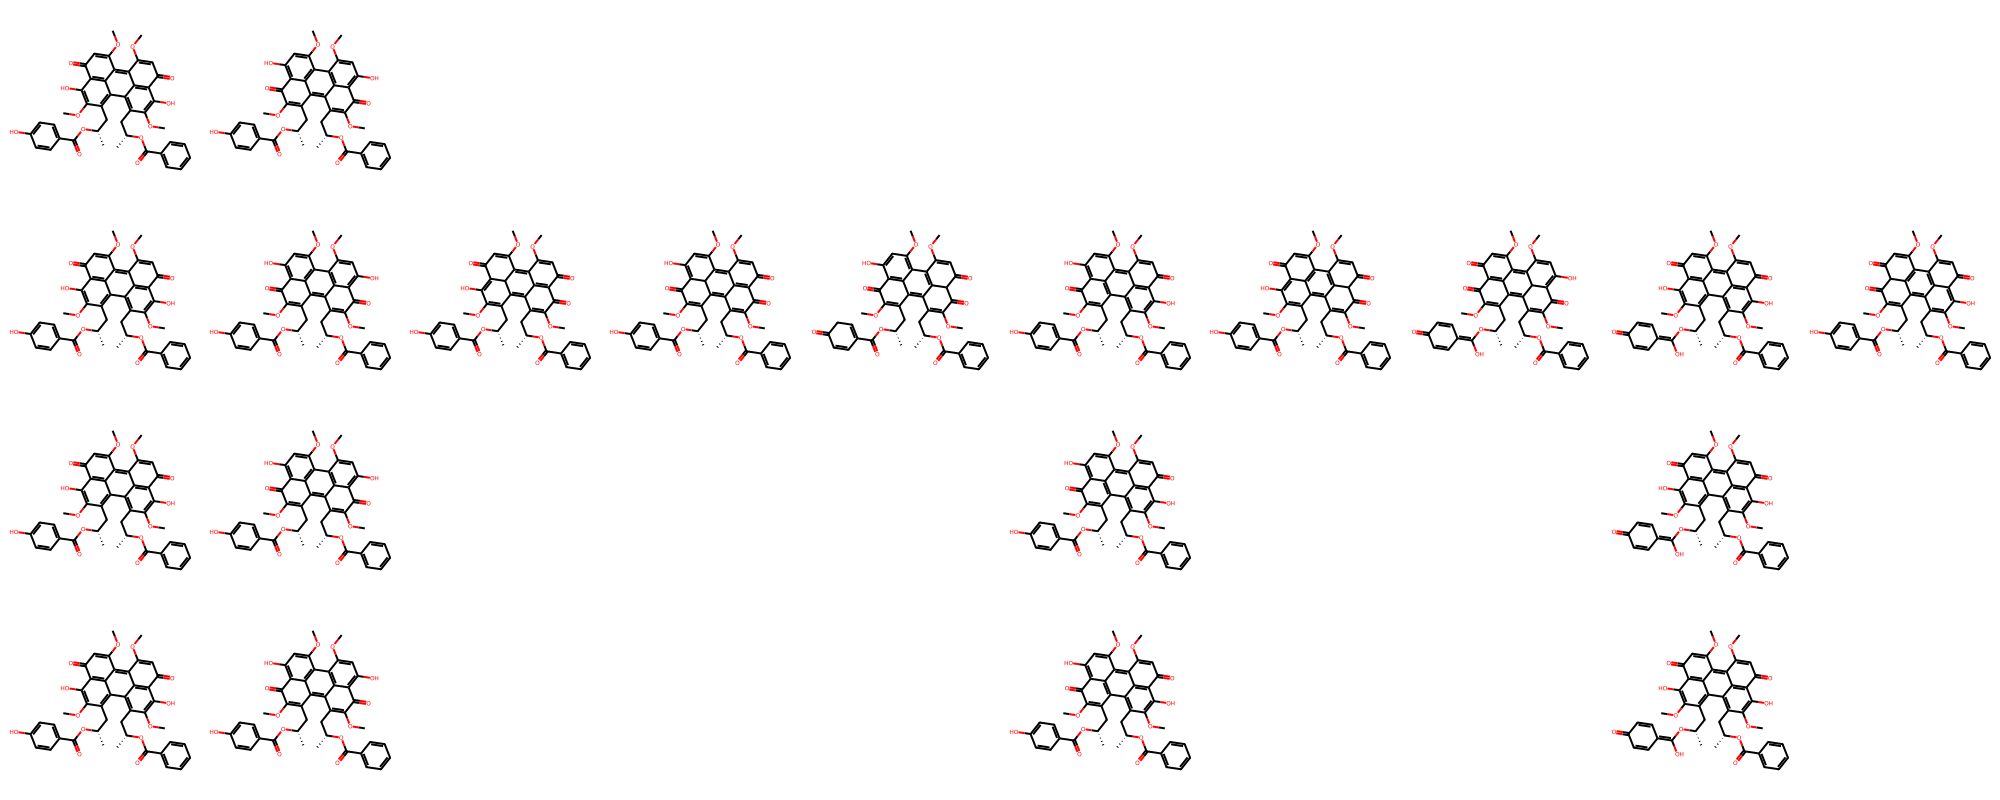

In [145]:
# Plot all four sets of tautomers

max_cols = 10
# Create nested (2D) data structures for Draw.MolsMatrixToGridImage
smls_matrix = [smls_expt, smls_nih_aligned, smls_v2_aligned, smls_v1_aligned]
tauts_matrix = [
    tauts_expt[:max_cols],
    tauts_nih_aligned[:max_cols],
    tauts_v2_aligned[:max_cols],
    tauts_v1_aligned[:max_cols],
]

# Align structures based on maximum common substructure (mcs)
# Exclude blank entries to avoid problem with aligning
tauts_all_flat = [item for sublist in tauts_matrix for item in sublist if item is not None]
mcs = rdFMCS.FindMCS(
    tauts_all_flat,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_all_flat:
    Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

len_tauts_matrix = len([item for sublist in tauts_matrix for item in sublist])
print(f"length of tauts_matrix, excluding blank cells: {len_tauts_matrix}")
for index, row in enumerate(tauts_matrix):
    print(f"  Row {index} has {len(row)} cells")

Draw.MolsMatrixToGridImage(
    molsMatrix=tauts_matrix, 
    # legendsMatrix=smls_matrix, 
    useSVG=True, 
    maxMols=1700
)

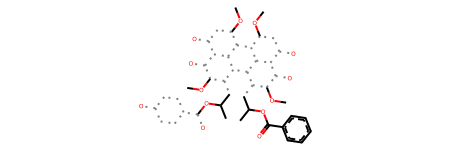

In [138]:
# Show how large, and thus effective, MCS is if use bondCompare=rdFMCS.BondCompare.CompareAny
mcs_mol

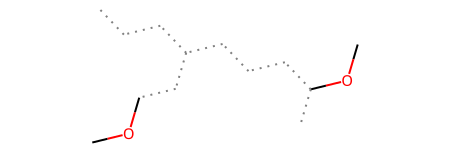

In [139]:
# Show how much smaller, and thus ineffective, MCS is if don't use bondCompare=rdFMCS.BondCompare.CompareAny
mcs_strict = rdFMCS.FindMCS(
    tauts_all_flat,
)
mcs_smarts_strict = mcs_strict.smartsString
mcs_mol_strict = Chem.MolFromSmarts(mcs_smarts_strict)
mcs_mol_strict

In [140]:
# Optional--Checking data quality
df_1 = df.filter(pl.col("Ref")==1).select("Ref","Size",*numbered_columns[:4])
df_1
df_1_InChI = df_1.select("Ref",*InChI_columns[:2])
df_1_InChI = (
    df_1_InChI
    .melt(id_vars="Ref", value_vars=InChI_columns[:2], value_name="InChI")
    .select("InChI")
    .drop_nulls()
)
unique_InChI = set(df_1_InChI["InChI"].to_list())
print(f"{unique_InChI=}")

df_1_smls = df_1.select("Ref",*SMILES_columns[:2])

df_1_smls = (
    df_1_smls
    .melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
    .select("sml")
    .drop_nulls()
)
unique_smls = df_1_smls["sml"].to_list()
unique_mols = [Chem.MolFromSmiles(sml) for sml in unique_smls]
unique_smls_canon = {Chem.MolToSmiles(mol) for mol in unique_mols}
unique_smls_to_inchi = {Chem.MolToInchi(mol) for mol in unique_mols}

print(f"{unique_smls_canon=}")
print(f"{unique_smls_to_inchi=}")

unique_InChI={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}
unique_smls_canon={'CC(=O)CC(C)=O', 'CC(=O)/C=C(/C)O'}
unique_smls_to_inchi={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}


Hi

In [141]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts
# check_same_keys(smls_tauts)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4eff0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4ef80>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4f1b0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4fa70>}]

In [142]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x28ec4f370>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x28ec4f300>}, {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x28ec4fc30>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x29be152a0>}]
[['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1'], ['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x28ec4f370>, <rdkit.Chem.rdchem.Mol object at 0x28ec4f300>], [<rdkit.Chem.rdchem.Mol object at 0x28ec4fc30>, <rdkit.Chem.rdchem.Mol object at 0x29be152a0>]]


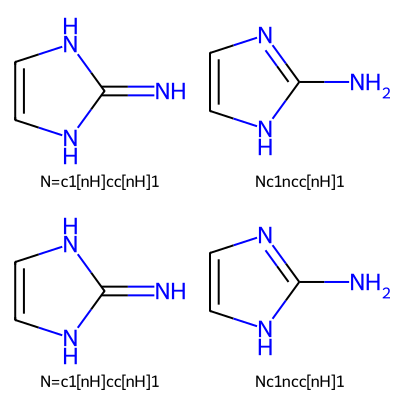

In [143]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)